# Linear Model for csv_v1

## This markdown file deals with the creation of Logistic Regression combined_csv_v1

In [1]:
# importing the required libraries libraries
import warnings, requests, zipfile, io

warnings.simplefilter("ignore")
import pandas as pd
from scipy.io import arff

import os
import boto3
import sagemaker
from sagemaker.image_uris import retrieve
from sklearn.model_selection import train_test_split

sagemaker.config INFO - Not applying SDK defaults from location: /etc/xdg/sagemaker/config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: /home/ec2-user/.config/sagemaker/config.yaml


# Function: initialize_s3_container

This function initializes an S3 bucket in a specified AWS region, creating a new storage container if it does not already exist. The function includes logic to handle both default and custom AWS regions.

In [2]:
import logging
# import boto3
from botocore.exceptions import ClientError
def initialize_s3_container(storage_name, locality=None):
    """
    Initialize an S3 storage bucket in a specified AWS region.
    If no region is specified, the bucket will default to 'us-east-1'.
    
    :param storage_name: Name of the bucket to create
    :param locality: AWS region for bucket creation, e.g., 'us-west-2'
    :return: True if bucket creation succeeds, otherwise False
    """
    try:
        if locality is None:
            s3_service = boto3.client("s3")
            s3_service.create_bucket(Bucket=storage_name)
        else:
            s3_service = boto3.client("s3", region_name=locality)
            config_location = {"LocationConstraint": locality}
            s3_service.create_bucket(
                Bucket=storage_name, CreateBucketConfiguration=config_location
            )
    except ClientError as error_log:
        logging.error(error_log)
        return False
    print(f"S3 Bucket: {storage_name} has been successfully created.")
    return True


In [3]:
# Function to verify if the bucket exists
def verify_bucket_presence(storage_identifier):
    s3_resource = boto3.client("s3")
    try:
        s3_resource.head_bucket(Bucket=storage_identifier)
        print(f"Bucket '{storage_identifier}' is already available.")
        return True
    except ClientError as error_detected:
        # If a 404 error is encountered, the bucket does not exist
        if error_detected.response["Error"]["Code"] == "404":
            print(f"Bucket '{storage_identifier}' is not found.")
            return False
        else:
            # Raise any other error encountered
            raise

# S3 Bucket Setup and Validation

In this section, we set up the S3 bucket and check if it already exists. If the bucket does not exist, we create it to ensure that all necessary storage resources are available for our project.

In [5]:
# Set the S3 bucket name with valid characters
s3_container_name = "u3265713-uni-can-dsts-assn1-ensembel-1"
# Fetch the S3 resource
s3_instance = boto3.Session().resource("s3")
# Check if the bucket exists
container_exists = verify_bucket_presence(s3_container_name)
# Create the bucket if it doesn't exist
if not container_exists:
    initialize_s3_container(s3_container_name)


Bucket 'u3265713-uni-can-dsts-assn1-ensembel-1' is not found.
S3 Bucket: u3265713-uni-can-dsts-assn1-ensembel-1 has been successfully created.


# Setting S3 Path Prefix and Uploading CSV Data to S3

In this section, we define a prefix for the S3 path and create a function to upload a DataFrame as a CSV file to an S3 bucket. This setup is essential for organizing and storing data in a structured manner within AWS S3.

In [9]:
# Setting the prefix for the S3 path
s3_prefix = "oncloud"

# Function to upload CSV data to AWS S3
def upload_csv_to_s3(file_name, subfolder, data_frame):
    csv_memory_buffer = io.StringIO()
    data_frame.to_csv(csv_memory_buffer, header=False, index=False)
    print(s3_instance.Bucket(s3_container_name))
    s3_instance.Bucket(s3_container_name).Object(os.path.join(s3_prefix, subfolder, file_name)).put(
        Body=csv_memory_buffer.getvalue()
    )


# Loading the Dataset

In [10]:
# Load the data
dataset_v1 = pd.read_csv("./combined_csv_v1.csv")

print(dataset_v1.head())
print(dataset_v1.shape)


   target  Distance  Quarter_2  Quarter_3  Quarter_4  Month_2  Month_3  \
0     0.0     689.0      False      False      False    False    False   
1     0.0     731.0      False      False      False    False    False   
2     0.0    1199.0      False      False      False    False    False   
3     0.0    1587.0      False      False      False    False    False   
4     0.0    1587.0      False      False      False    False    False   

   Month_4  Month_5  Month_6  ...  Dest_DEN  Dest_DFW  Dest_IAH  Dest_LAX  \
0    False    False    False  ...     False     False      True     False   
1    False    False    False  ...     False     False     False     False   
2    False    False    False  ...      True     False     False     False   
3    False    False    False  ...     False     False     False     False   
4    False    False    False  ...     False     False     False     False   

   Dest_ORD  Dest_PHX  Dest_SFO  DepHourofDay_7-12  DepHourofDay_13-18  \
0     False     Fa

# Creating a Copy of the Dataset

In [11]:
# Copying the data 
df = dataset_v1.copy()

# Data Transformation: Converting Boolean Values

In [12]:
# Replacing True/False with 1/0 directly in df
df = df.replace({True: 1, False: 0})
df.head(5)


,target,Distance,Quarter_2,Quarter_3,Quarter_4,Month_2,Month_3,Month_4,Month_5,Month_6,...,Dest_DEN,Dest_DFW,Dest_IAH,Dest_LAX,Dest_ORD,Dest_PHX,Dest_SFO,DepHourofDay_7-12,DepHourofDay_13-18,DepHourofDay_19-23
0,0.0,689.0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
1,0.0,731.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,0.0,1199.0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
3,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,0
4,0.0,1587.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


# Splitting the dataset

In [13]:
# Split the data into training and a combined testing/validation set (70% train, 30% test/validate)
training_data, testing_validation_data = train_test_split(
    df, test_size=0.3, random_state=42, stratify=df["target"]
)

# Further split the testing_validation_data set into separate testing and validation sets (15% each of the original data)
testing_data, validation_data = train_test_split(
    testing_validation_data,
    test_size=0.5,
    random_state=42,
    stratify=testing_validation_data["target"],
)

In [14]:
# Printing the shapes of each set 
print(training_data.shape)
print(testing_data.shape)
print(validation_data.shape)

(1144913, 75)
(245338, 75)
(245339, 75)


# Defining File Names for Data Subsets

In [15]:
# Set the names of the CSV files for each data subset
# These file names will be used to save the training, testing, and validation datasets 
# as CSV files, allowing for easy upload to S3 and subsequent use in modeling.
training_file_name = "data_v1_train.csv"      # Filename for the training dataset
testing_file_name = "data_v1_test.csv"        # Filename for the testing dataset
validation_file_name = "data_v1_validate.csv" # Filename for the validation dataset


In [16]:
# Upload each dataset subset to the specified S3 locations using the `upload_csv_to_s3` function
# This will ensure that the data is accessible for model training in SageMaker
upload_csv_to_s3(training_file_name, "train", training_data)      # Upload training data to 'train' subfolder
upload_csv_to_s3(testing_file_name, "test", testing_data)         # Upload testing data to 'test' subfolder
upload_csv_to_s3(validation_file_name, "validate", validation_data) # Upload validation data to 'validate' subfolder


s3.Bucket(name='u3265713-uni-can-dsts-assn1-ensembel-1')
s3.Bucket(name='u3265713-uni-can-dsts-assn1-ensembel-1')
s3.Bucket(name='u3265713-uni-can-dsts-assn1-ensembel-1')


# Setting Up SageMaker Training Environment

This section sets up the SageMaker environment for training an XGBoost model. First, it defines input channels to specify the S3 locations for the training and validation datasets, ensuring the data is accessible during model training. Next, it initializes the SageMaker session, retrieves the XGBoost container image, and configures hyperparameters for training. Finally, the XGBoost estimator is set up, specifying model configurations and training parameters required to run the job on SageMaker.

In [17]:
# Import required libraries for setting up the XGBoost container and S3 session
import boto3
from sagemaker.image_uris import retrieve

# Retrieve the XGBoost container image URI for the specified AWS region
xgb_container_uri = retrieve("xgboost", "us-east-1", version="1.0-1")

# Define hyperparameters for the XGBoost model
# - num_round: Number of training rounds
# - eval_metric: Evaluation metric to optimize
# - objective: Learning task and corresponding objective
model_hyperparameters = {
    "num_round": "42",
    "eval_metric": "auc",
    "objective": "binary:logistic"
}

# Import the SageMaker library for model deployment
import sagemaker

# Set up the SageMaker session to ensure it's aligned with the S3 bucket region
# Specifying 'us-east-1' as the region in the session
sagemaker_session_instance = sagemaker.Session(boto3.session.Session(region_name="us-east-1"))

# Define the S3 output location where model artifacts will be stored after training
# Formatting the S3 path using the predefined S3 bucket name and a custom prefix
s3_model_output_path = "s3://{}/{}/output/".format(s3_container_name, s3_prefix)

# Initialize the XGBoost estimator for SageMaker
# - container: Specifies the XGBoost container URI
# - role: SageMaker execution role for accessing AWS resources
# - instance_count: Number of instances for model training
# - instance_type: Type of instance to use (ml.c5.4xlarge)
# - output_path: S3 path to store the model output
# - hyperparameters: Training configuration for the model
# - sagemaker_session: Session that ties to the same AWS region as the bucket
xgboost_estimator = sagemaker.estimator.Estimator(
    xgb_container_uri,
    sagemaker.get_execution_role(),
    instance_count=1,
    instance_type="ml.c5.4xlarge",
    output_path=s3_model_output_path,
    hyperparameters=model_hyperparameters,
    sagemaker_session=sagemaker_session_instance,
)


In [18]:
# Define the input channels for training and validation data for SageMaker
# Using formatted S3 paths to specify the location of training and validation CSV files

# Set up the training data channel
# This channel points to the S3 location where the training CSV file is stored
training_data_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/train/{}".format(s3_container_name, s3_prefix, training_file_name), content_type="text/csv"
)

# Set up the validation data channel
# This channel points to the S3 location where the validation CSV file is stored
validation_data_channel = sagemaker.inputs.TrainingInput(
    "s3://{}/{}/validate/{}".format(s3_container_name, s3_prefix, validation_file_name),
    content_type="text/csv",
)

# Print confirmation of the data channels for verification
print(f"Data channels setup:\n Validation Channel: {validation_data_channel} \n Training Channel: {training_data_channel}")

# Combine both training and validation channels into a dictionary for easy reference
data_input_channels = {"train": training_data_channel, "validation": validation_data_channel}


Data channels setup:
 Validation Channel: <sagemaker.inputs.TrainingInput object at 0x7f4a507c7070> 
 Training Channel: <sagemaker.inputs.TrainingInput object at 0x7f4a507c6d10>


# Initiating Model Training and deployment for predictions

In [19]:
# Start training the XGBoost model using the specified input channels
# - inputs: Passes in the dictionary of data channels with 'train' and 'validation' paths
# - logs=False: Disables the logging output during training
xgboost_estimator.fit(inputs=data_input_channels, logs=False)


INFO:sagemaker:Creating training-job with name: sagemaker-xgboost-2024-11-03-11-17-28-525



2024-11-03 11:17:29 Starting - Starting the training job.
2024-11-03 11:17:43 Starting - Preparing the instances for training....
2024-11-03 11:18:06 Downloading - Downloading input data..
2024-11-03 11:18:21 Downloading - Downloading the training image....
2024-11-03 11:18:47 Training - Training image download completed. Training in progress.........
2024-11-03 11:19:30 Uploading - Uploading generated training model.
2024-11-03 11:19:43 Completed - Training job completed


In [20]:
# Deploy the trained XGBoost model for real-time predictions
# - initial_instance_count: Specifies the number of instances to launch
# - serializer: Converts input data to CSV format for compatibility with the model
# - instance_type: Defines the instance type to use for deployment
xgboost_predictor = xgboost_estimator.deploy(
    initial_instance_count=1,
    serializer=sagemaker.serializers.CSVSerializer(),
    instance_type="ml.c5.4xlarge",
)


INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-11-03-11-19-45-159
INFO:sagemaker:Creating endpoint-config with name sagemaker-xgboost-2024-11-03-11-19-45-159
INFO:sagemaker:Creating endpoint with name sagemaker-xgboost-2024-11-03-11-19-45-159


-----!

# Preparing Batch Data for Predictions

In [21]:
# Extract features from the testing dataset by selecting all columns except the target column
# This dataset (batch_X_data) will be used for batch prediction
batch_X_data = testing_data.iloc[:, 1:]
# Replace boolean values with numeric values
# - True values are replaced with 1, False values with 0 for compatibility with model input
# Uncomment if needed
# batch_X_data = batch_X_data.replace({True: 1, False: 0})
# Specify the filename for the batch input file for uploading to S3
# This file will contain the input features for batch predictions
batch_input_filename = "batch_input_data.csv"
# Save and upload the batch input file to S3 for batch processing
# This function will place the file in the specified S3 folder
upload_csv_to_s3(batch_input_filename, "batch-in", batch_X_data)


s3.Bucket(name='u3265713-uni-can-dsts-assn1-ensembel-1')


In [22]:
# Check for any missing values in the batch input data
# - .isnull().sum().sum() will return the total count of missing values across all columns
missing_values_count = batch_X_data.isnull().sum().sum()
print(f"Total missing values in batch input data: {missing_values_count}")

# Display the shape of the batch input data
# - This provides the number of rows (data points) and columns (features) in the batch dataset
batch_data_shape = batch_X_data.shape
print(f"Batch input data shape: {batch_data_shape}")

Total missing values in batch input data: 0
Batch input data shape: (245338, 74)


# Batch Transformation for Large-Scale Predictions


In [24]:
# Set the output location for the batch transformation results in S3
# This will store the model's batch prediction results in the specified S3 folder
batch_output_location = "s3://{}/{}/batch-out/".format(s3_container_name, s3_prefix)

# Set the input location for the batch transformation
# This points to the S3 folder where the batch input data file is stored
batch_input_location = "s3://{}/{}/batch-in/{}".format(s3_container_name, s3_prefix, batch_input_filename)

# Create a transformer object from the trained XGBoost model for batch transformation
# - instance_count: Number of instances to use for the batch transformation
# - instance_type: Type of instance (ml.c5.2xlarge) for running the batch transform job
# - strategy: Specifies the data processing strategy ('MultiRecord' processes multiple records per batch)
# - assemble_with: Defines how to combine records in the output ('Line' combines records line by line)
# - output_path: Specifies the S3 path where the batch output will be stored
xgboost_transformer = xgboost_estimator.transformer(
    instance_count=1,
    instance_type="ml.c5.2xlarge",
    strategy="MultiRecord",
    assemble_with="Line",
    output_path=batch_output_location,
)


INFO:sagemaker:Creating model with name: sagemaker-xgboost-2024-11-03-11-24-31-322


In [25]:
# Start the batch transform job for generating predictions on the batch input data
# - data: Specifies the S3 location of the batch input file
# - data_type: Defines the data source type; "S3Prefix" indicates data is stored in S3
# - content_type: Specifies the format of the input data ("text/csv" for CSV files)
# - split_type: Determines how to split the input data; "Line" treats each line as a separate record
xgboost_transformer.transform(
    data=batch_input_location, data_type="S3Prefix", content_type="text/csv", split_type="Line"
)

# Wait for the batch transform job to complete
# This ensures that subsequent steps don’t proceed until batch processing is finished
xgboost_transformer.wait()

INFO:sagemaker:Creating transform job with name: sagemaker-xgboost-2024-11-03-11-24-36-336


...............................[2024-11-03:11:29:40:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-03:11:29:40:INFO] No GPUs detected (normal if no gpus installed)
[2024-11-03:11:29:40:INFO] nginx config: 
worker_processes auto;
daemon off;
pid /tmp/nginx.pid;
error_log  /dev/stderr;
worker_rlimit_nofile 4096;
events {
  worker_connections 2048;
}
http {
  include /etc/nginx/mime.types;
  default_type application/octet-stream;
  access_log /dev/stdout combined;
  upstream gunicorn {
    server unix:/tmp/gunicorn.sock;
  }
  server {
    listen 8080 deferred;
    client_max_body_size 0;
    keepalive_timeout 3;
    location ~ ^/(ping|invocations|execution-parameters) {
      proxy_set_header X-Forwarded-For $proxy_add_x_forwarded_for;
      proxy_set_header Host $http_host;
      proxy_redirect off;
      proxy_read_timeout 60s;
      proxy_pass http://gunicorn;
    }
    location / {
      return 404 "{}";
    }
  }
}
[2024-11-03 11:29:41 +0000] [27] [INFO] Starting guni

# Retrieving and Processing Batch Prediction Results

In [26]:
# Initialize the S3 client to interact with S3 resources
s3_client = boto3.client("s3")

# Retrieve the batch output file generated by the batch transform job
# - Bucket: Specifies the S3 bucket name
# - Key: Specifies the path to the output file generated by the batch transform job
batch_output_object = s3_client.get_object(
    Bucket=s3_container_name, Key="{}/batch-out/{}".format(s3_prefix, "batch_input_data.csv.out")
)

# Read the batch output file into a DataFrame
# - Converts the binary content of the S3 object to a CSV format with "class" as the column name
predicted_target = pd.read_csv(io.BytesIO(batch_output_object["Body"].read()), names=["class"])


In [27]:
# Function to convert predicted probability values to binary labels (0 or 1)
# - Values above the threshold (0.3) are classified as 1 (positive class)
# - Values at or below the threshold are classified as 0 (negative class)
def convert_to_binary(value):
    threshold_value = 0.3  # Set threshold for classification
    if value > threshold_value:
        return 1
    else:
        return 0

# Apply the binary conversion function to the predicted target values
# - This converts the "class" column in predicted_target to binary values based on the threshold
predicted_target_binary = predicted_target["class"].apply(convert_to_binary)

# Print the first five binary-converted predictions for verification
print(predicted_target_binary.head(5))

# Display the first five rows of the test dataset for comparison
print(testing_data.head(5))

# Extract the true labels from the testing dataset
# - Selects the first column, which contains the actual target labels
actual_test_labels = testing_data.iloc[:, 0]

# Display the first five labels for verification
print(actual_test_labels.head(5))


0    0
1    0
2    0
3    0
4    0
Name: class, dtype: int64
         target  Distance  Quarter_2  Quarter_3  Quarter_4  Month_2  Month_3  \
470151      0.0    1947.0          1          0          0        0        0   
985696      0.0     925.0          0          0          1        0        0   
394886      0.0     862.0          0          0          0        1        0   
924542      0.0    1744.0          0          1          0        0        0   
1533313     0.0     936.0          1          0          0        0        0   

         Month_4  Month_5  Month_6  ...  Dest_DEN  Dest_DFW  Dest_IAH  \
470151         0        1        0  ...         0         0         0   
985696         0        0        0  ...         0         0         0   
394886         0        0        0  ...         1         0         0   
924542         0        0        0  ...         0         0         0   
1533313        0        0        1  ...         0         1         0   

         Dest_LAX  

# Prediction Results of model

In [28]:
# Import classification_report from sklearn to evaluate model performance
from sklearn.metrics import classification_report

# Generate and display the classification report for the test data
# - Compares the actual test labels with the binary-converted predicted labels
print("Classification Report on Test Data")
print(classification_report(actual_test_labels, predicted_target_binary))

Classification Report on Test Data
              precision    recall  f1-score   support

         0.0       0.83      0.88      0.85    193838
         1.0       0.40      0.30      0.34     51500

    accuracy                           0.76    245338
   macro avg       0.61      0.59      0.60    245338
weighted avg       0.74      0.76      0.75    245338



In [29]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
# Function to plot a confusion matrix
# This function generates a heatmap to visualize the confusion matrix,
# which helps assess the accuracy of classification by comparing actual and predicted labels.
def display_confusion_matrix(actual_labels, predicted_labels):
    # Generate the confusion matrix
    # The matrix compares actual labels with predicted labels to show true positives, false positives, etc.
    confusion_mat = confusion_matrix(actual_labels, predicted_labels)
    # Create a heatmap for the confusion matrix
    # This provides a visual representation of the matrix for easy interpretation.
    sns.heatmap(
        confusion_mat,
        annot=True,               # Display numerical values within each cell
        fmt="d",                  # Format as integer values
        cmap="Blues",             # Color scheme for the heatmap
        xticklabels=["On-Time", "Delayed"],  # Labels for the x-axis (predicted outcomes)
        yticklabels=["On-Time", "Delayed"],  # Labels for the y-axis (actual outcomes)
    )
    # Label the plot axes and title
    plt.xlabel("Predicted Labels")  # Label for the x-axis
    plt.ylabel("Actual Labels")     # Label for the y-axis
    plt.title("Confusion Matrix")   # Title of the plot
    plt.show()                      # Display the plot

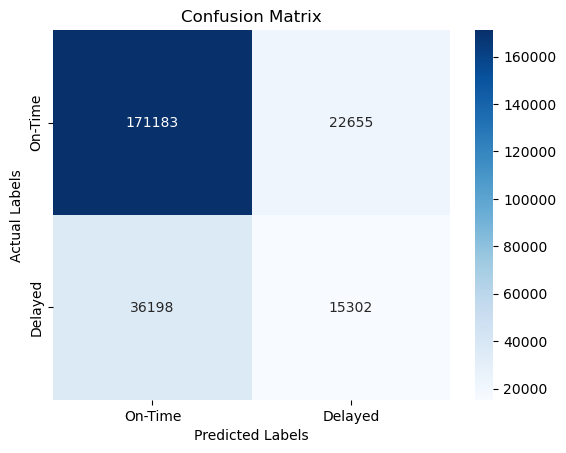

In [30]:
# Plot the confusion matrix to visualize model performance on the test data
# - Compares the true test labels with the predicted binary labels
display_confusion_matrix(actual_test_labels, predicted_target_binary)